# Pola figur: całkowanie analityczne i metodą Monte Carlo

W jaki sposób można obliczyć pole figury o zadanym kształcie, który jest trudny do analitycznego opisu?
W tym pliku przedyskutujemy sposób obliczania pól figur oparty na metodach losowych z wykorzystaniem prostych spacerów losowych. Porównamy wyniki z obliczeniami analitycznymi na konkretnym przykładzie.

<div class="alert alert-block alert-info"> 
Aby wzbogacić nasz repertuar matematyczny wykorzystamy w tym pliku funkcjonalność SageMath - obszernej biblioteki, która rozwija metody symboliczne Pythona. Do uruchomienia tego pliku będziesz potrzebować jądra "SageMath" w wersji co najmniej 8.9. Bez instalacji ten plik można rekompilować np. w przeglądarkowej wersji SageMath pod adresem cocalc.com.</div>

<h2>Problem</h2>
<div class="alert alert-block alert-success"> 
Oblicz z dokładnością $0.01$ pole wewnątrz następującej figury.</div>

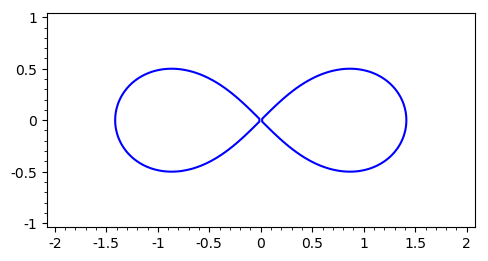

In [129]:
x,y=var('x,y')
implicit_plot((x**2+y**2)**2-2*(x**2-y**2),(x,-2,2),(y,-2,2),figsize=[5,5],ymax=1,ymin=-1,xmin=-2,xmax=2)

## Obliczenia analityczne

W naszym pierwszym podejściu obliczymy pole wewnątrz "ósemki" w sposób dokładny (analityczny). W tym celu musimy rozwiazać uwikłane równanie opisujące krzywą.

### Rozwiązanie równania
Najpierw "rozwiązujemy" nasze równanie uwikłane.

$$(x^2+y^2)^2=2(x^2-y^2)$$

In [7]:
solv=solve((x**2+y**2)**2-2*(x**2-y**2)==0,(x,y))

In [8]:
pretty_print(solv)

[[x == r1, y == sqrt(-r1^2 - sqrt(4*r1^2 + 1) - 1)], [x == r2, y == -sqrt(-r2^2 - sqrt(4*r2^2 + 1) - 1)], [x == r3, y == sqrt(-r3^2 + sqrt(4*r3^2 + 1) - 1)], [x == r4, y == -sqrt(-r4^2 + sqrt(4*r4^2 + 1) - 1)]]

<div class="alert alert-block alert-success"> 
<p>Powyższy obiekt przechowuje wszystke "lokalne" rozwiązania naszego równania. Wykorzystamy je do napisania równań funkcji, które kawałkami opisują kształt naszej "ósemki" (precyzyjnie: lemniskaty Bernoulliego).</p>

<p><b>UWAGA:</b> dwie spośród podanych wyżej funkcji rozwiązań nie opisują rzeczywistych części wykresu - ignorujemy je.</p></div>

In [9]:
y1=solv[2][1].rhs() #wybieramy prawą stronę trzeciego równania
r=y1.variables()[0] #odnosimy się do jego wewnętrznej zmiennej symbolicznej
f=y1.subs({r:x}) #i podstawiamy ustaloną przez nas od początku zmienną x

#sprawdzamy równość podstawienia
assert bool(f==sqrt(-x^2 + sqrt(4*x^2 + 1) - 1))

#to będzie nasza "rozwiązana" funkcja
funkcja=sqrt(-x^2 + sqrt(4*x^2 + 1) - 1)

### W jakim prostokącie mieści się wykres lemniskaty?

Obliczmy teraz formalnie liczby $a$ i $b$ takie, że zbiór punktów

$$L=\{(x,y)\in\mathbb{R}^2: (x^2+y^2)^2=2(x^2-y^2)\}$$
spełnia

$$\max_{(x,y)\in L} x = -  \min_{(x,y)\in L} x = a$$

oraz 

$$\max_{(x,y)\in L} y = -  \min_{(x,y)\in L} y = b$$

Wartość parametru $a$ przy nam się przy obliczaniu pola (całki) metodą analityczną. Parametr $b$ będzie nam potrzebny również przy obliczaniu pola numerycznie metodą Monte Carlo.

Liczbę $a$ wyznaczamy określając dziedzinę funkcji $f(x) = \sqrt{\sqrt{4x^2+1}-x^2-1}$

In [22]:
#UWAGA: w SageMath można używać zarówno ** jak i ^ jako symbolu potęgowania (w zwykłym Python symbol ^ oznacza
#operację XOR; w SageMath ta operacja jest oznaczona jako ^^)
eq1=0==-x^2 + sqrt(4*x^2 + 1) - 1 #formułujemy zerowanie argumenty pod zewnętrznym pierwiastkiem

#wykonujemy przekształcenia na równaniu eq1, aby doprowadzić je do wygodnej wielomianowej postaci
eq1=eq1.add_to_both_sides(x^2+1)
eq1=eq1*eq1 #podniesienie obu stron do kwadratu
eq1=eq1.add_to_both_sides(-(4*x^2+1))
eq1

(x^2 + 1)^2 - 4*x^2 - 1 == 0

In [23]:
solve(eq1,x)

[x == -sqrt(2), x == sqrt(2), x == 0]

Zatem nasz parametr $a$ wynosi $\sqrt{2}$.

Liczbę $b$ obliczymy wyznaczając maksimum osiągane przez funkcję $f(x)$ na przedziale $(0,\sqrt{2})$.

<div class="alert alert-block alert-success"> 
Obliczamy pochodną funkcji $f$ i zauważamy, że mianownik jest dodatni. Do określenia przebiegu funkcji użyjemy informacji o znaku licznika.</div>

In [33]:
pochodnaf=funkcja.derivative(x).factor()
licznik=pochodnaf.numerator()
mianownik=pochodnaf.denominator()

In [34]:
#licznik
pretty_print(licznik)

-x*(sqrt(4*x^2 + 1) - 2)

In [35]:
#mianownik
pretty_print(mianownik)

sqrt(4*x^2 + 1)*sqrt(-x^2 + sqrt(4*x^2 + 1) - 1)

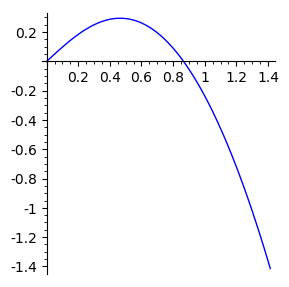

In [104]:
#wykres licznika pochodnej
plot(licznik,(x,0,sqrt(2)),figsize=[3,3])

<div class="alert alert-block alert-success"> 
Z postaci funkcji $-x(\sqrt{4x^2+1}-2)$ wynika, że jest dodatnia dla $x<c$ i ujemna dla $x>c$, gdzie $c$ jest jedynym miejscem zerowym tej funkcji. Obliczmy zatem $c$.</div>

In [41]:
with assuming(x>0):
    print(solve(licznik==0,x))

[
x == 1/2*sqrt(3)
]


Czyli funkcja $f(x)$ jest rosnąca na przedziale $\left(0,\frac{\sqrt{3}}{2}\right)$ i malejąca na przedziale $\left(\frac{\sqrt{3}}{2},\sqrt{2}\right)$. 

<div class="alert alert-block alert-success"> 
W punkcie $x=\frac{\sqrt{3}}{2}$ funkcja $f(x)$ osiąga maksimum równe $b=1/2$.</div>

In [42]:
funkcja.subs({x:sqrt(3)/2})

1/2

Wizualizacja pudełka ograniczającego kształt lemniskaty

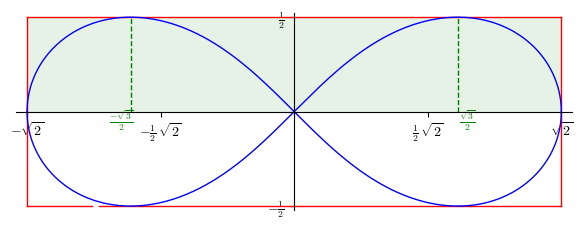

In [231]:
#rysowanie lemniskaty ze zmodyfikowaną skalą
pup=plot(f,(x,-sqrt(2),sqrt(2)),xmin=-sqrt(2)-0.2,xmax=sqrt(2)+0.2,ticks=[[-sqrt(2),-sqrt(2)/2,0,sqrt(2)/2,sqrt(2)],[-1/2,0,1/2]],tick_formatter=[sqrt(2)/2,1/2])
pdown=plot(-f,(x,-sqrt(2),sqrt(2)),ticks=[[-sqrt(3)/2,0,sqrt(3)/2],[-1/2,0,1/2]])
lemniskata=pdown+pup

#pudełko dookoła lemniskaty
pudelko=plot(1/2,(x,-sqrt(2),sqrt(2)),color='red',fill='axis',fillcolor='green',fillalpha=0.1)+line([(-sqrt(2),-1/2),(-sqrt(2),1/2)],color='red')
pudelko+=plot(-1/2,(x,-sqrt(2),sqrt(2)),color='red')+line([(sqrt(2),-1/2),(sqrt(2),1/2)],color='red')

#linie maksimów (przerywane, zielone)
linie=line([(sqrt(3)/2,0),(sqrt(3)/2,1/2)],linestyle="--",color="green")
linie+=line([(-sqrt(3)/2,0),(-sqrt(3)/2,1/2)],linestyle="--",color="green")

#dodatkowe etykiety
teksty=text("$\\frac{\\sqrt{3}}{2}$",(sqrt(3)/2+0.05,-0.05),color='green')
teksty+=text("$\\frac{-\\sqrt{3}}{2}$",(-sqrt(3)/2-0.05,-0.05),color='green')

#końcowy wykres
show(pudelko+lemniskata+teksty+linie,figsize=[6,6],aspect_ratio=1)

Teraz możemy obliczyć wartość pola wewnątrz figury jako sumę czterech całek (każda odpowiada jednej ćwiartce figury).

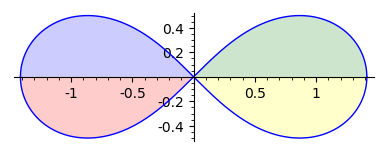

In [227]:
plg=plot(f,(x,-sqrt(2),0),fill='min',fillcolor='blue', fillalpha=.2)
pld=plot(-f,(x,-sqrt(2),0),fill='max',fillcolor='red', fillalpha=.2)
ppg=plot(f,(x,0,sqrt(2)),fill='min',fillcolor='green', fillalpha=.2)
ppd=plot(-f,(x,0,sqrt(2)),fill='max',fillcolor='yellow', fillalpha=.2)
show(plg+pld+ppg+ppd,figsize=[4,4],aspect_ratio=1)

In [105]:
#Pole wewnątrz lemniskaty
2*integrate(funkcja,(x,-sqrt(2),sqrt(2))).n()

2.0000000070692856

In [114]:
#szybsza metoda numerycznego całkowania z kontrolą błędu (wartość całki, błąd)
integral_numerical(2*funkcja,-sqrt(2),sqrt(2),max_points=100)

(2.0000000070692856, 1.4825283125400555e-06)

Hmm, być może wartość pola wynosi $2$, więc wartość całki z $f(x)$ wynosi $1$ w przedziale $(-\sqrt{2},\sqrt{2})$. Sprawdźmy to !

<h3> Hipoteza</h3>
<div class="alert alert-block alert-info"> 

$$P=\int_{0}^{\sqrt{2}}\sqrt{\sqrt{4x^2 + 1}-x^2 - 1}\: dx = \frac{1}{2}$$</div>

Wyznaczymy najpierw parametryzację promieniem i kątem $(r,t)$ dla naszego równania krzywej Bernoulliego.

Korzystamy ze standardowej zamiany zmiennych

$$x=r\cos(t),\quad y=r\sin(t)$$

In [131]:
r,t=var('r,t')
((x**2+y**2)**2-2*(x**2-y**2)).subs({x:r*cos(t),y:r*sin(t)}).simplify_full().factor()

(r^2 + 4*sin(t)^2 - 2)*r^2

<div class="alert alert-block alert-success"> 
Zatem równanie uwikłane lemniskaty we współrzędnych biegunowych $(r,t)$ jest postaci

$$r^2+4\sin(t)^2-2=0$$</div>

In [132]:
solve(r^2 + 4*sin(t)^2 - 2==0,r)

[r == -sqrt(-4*sin(t)^2 + 2), r == sqrt(-4*sin(t)^2 + 2)]

Zatem możemy sparametryzować naszą krzywą następującymi równaniami

$x=r \cos(t), \quad y=r \sin(t)$, gdzie

$r=\pm \sqrt{2-4 \sin(t)^2}=\pm \sqrt{2\cos(t)}=\pm \sqrt{4\cos(t)^2-2}$

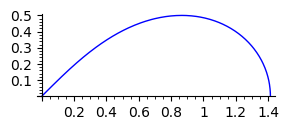

In [225]:
parametric_plot((sqrt(2*cos(2*t))*cos(t),sqrt(2*cos(2*t))*sin(t)),(t,0,pi/4) ,figsize=[3,3])

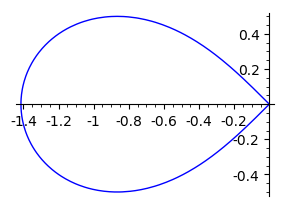

In [224]:
parametric_plot((-sqrt(2*cos(2*t))*cos(t),-sqrt(2*cos(2*t))*sin(t)),(t,-pi/4,pi/4),figsize=[3,3])

Świetnie, zatem możemy naszą całkę $P$  przetransformować do postaci, gdzie będzie zależała wyłącznie od zmiennej $t$.

In [276]:
f1=funkcja.subs({x:sqrt(4*cos(t)**2-2)*cos(t)})
d1=x.subs({x:sqrt(4*cos(t)**2-2)*cos(t)}).derivative(t)

In [263]:
f1=f1.simplify_full()
pretty_print(f1)

sqrt(-4*cos(t)^4 + 2*cos(t)^2 + sqrt(16*cos(t)^4 - 8*cos(t)^2 + 1) - 1)

Zauważmy, że 

$$16\cos(t)^4 - 8\cos(t)^2 + 1 = (4\cos(t)^2 - 1)^2$$

oraz

$4\cos(t)^2 - 1\geq 0$ skoro $t\in(0,\frac{\pi}{4})$

In [285]:
f1=sqrt(-4*cos(t)**4+2*cos(t)**2+(4*cos(t)**2-1)-1)
pretty_print(f1.simplify_full())

sqrt(-4*sin(t)^4 + 2*sin(t)^2)

To wyrażenie uprościmy dalej

$$\sqrt{-4\sin(t)^4+2\sin(t)^2} = \sin(t)\sqrt{2(1-2\sin(t)^2)}=\sin(t)\sqrt{4\cos(t)^2-2}$$ na mocy naszych założeń o $t$.

In [300]:
f1=(sin(t)*sqrt(4*cos(t)**2-2))
d1=d1.factor()
pretty_print((f1*d1).simplify().expand().simplify_full())

-2*(4*cos(t)^2 - 1)*sin(t)^2

In [301]:
(f1*d1).simplify().expand().simplify_full()

-2*(4*cos(t)^2 - 1)*sin(t)^2

<div class="alert alert-block alert-success"> 
Zatem metodą dokładną pole wewnątrz lemniskaty jest czterokrotnym polem jednego parametryzowanego kawałka $P$. Parametryzacja jest zgodna z orientacją osi, gdy $t$ maleje od $\frac{\pi}{4}$ do $0$. Czyli

$P = \int_{x=0}^{x=\sqrt{2}} \sqrt{\sqrt{4x^2 + 1}-x^2-1}\: dx=\int_{t=\pi/4}^{t=0}-2(4\cos(t)^2-1)\cdot \sin(t)^2 dt$ </div>

In [133]:
integrate(-2*(4*cos(t)^2 - 1)*sin(t)^2,(t,pi/4,0))

1/2

<h3>Problem</h3>
<i>Czy możemy obliczyć przybliżenie pola lemniskaty za pomocą metody nieanalitycznej?</i>

<h2> Metoda numeryczna 1:</h2>
<div class="alert alert-block alert-success"> 
Wygenerujemy zbiór punktów na płaszczyźnie w obszarze, w którym mieści się cała lemniskata.</div>

Nasza lemniskata styka się z bokami prostokąta $A=[-\sqrt{2},\sqrt{2}]\times [-1/2,1/2]$.

Pole tego prostokąta wynosi $2\sqrt{2}$. Wylosujemy punkty w obu przedziałach (jednostajnie) i zobaczymy ile ich potrzeba, aby uzyskać rozsądne przybliżenie.

<b>UWAGA:</b> W tym rozwiązaniu zastosujemy generator liczb pseudolosowych, który produkuje dla nas liczby z przedziału $[0,1]$ z rozkładem jednostajnym.

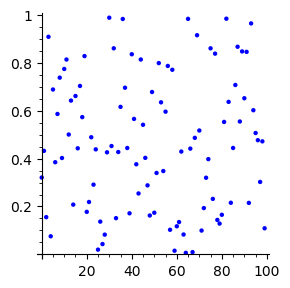

In [222]:
r=random() #zmienna o rozkładzie jednostajnym i wartościac w przedziale [0,1]
list_plot([random() for i in range(0,100)],figsize=[3,3])

Generujemy losowy punkt w prostokącie $A$

In [137]:
def LosowyPunkt():
    x=sqrt(2).n()*(2*random()-1)
    y=random()-1/2
    return (x,y)

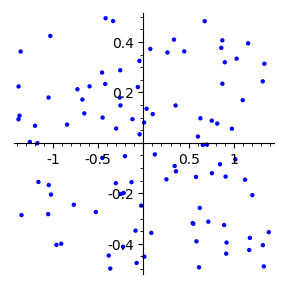

In [221]:
li=[point(LosowyPunkt()) for _ in range(0,100)]
show(sum(li),figsize=[3,3])

Teraz potrzebujemy funkcji, która wskaże czy zadany punkt znajduje się we wnętrzu lemniskaty lub nie.

In [141]:
def CzyWewnatrzLemniskaty(punkt):
    x,y=punkt
    f=sqrt(-x^2 + sqrt(4*x^2 + 1) - 1)
    if abs(y)<=f:
        return True
    else:
        return False

In [146]:
CzyWewnatrzLemniskaty((1/4,1/8))

True

In [147]:
CzyWewnatrzLemniskaty((0,1))

False

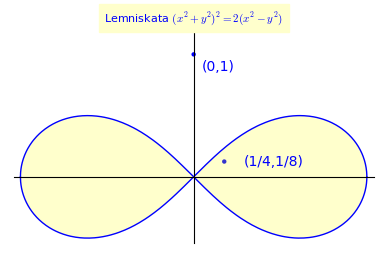

In [198]:
lem=plot(f,(x,-sqrt(2),sqrt(2)),fill='min',fillcolor='yellow', fillalpha=.2,figsize=[4,4],aspect_ratio=1,ticks=[[],[]])
lem+=plot(-f,(x,-sqrt(2),sqrt(2)),fill='max',fillcolor='yellow', fillalpha=.2)
pt=point((1/4,1/8))+point((0,1))
teksty=text("(1/4,1/8)",(1/4+0.4,1/8))+text("(0,1)",(+0.2,1-0.1))
teksty+=text("Lemniskata $(x^2+y^2)^2=2(x^2-y^2)$", (0.0,1.3), background_color=(1,1,0.8),fontsize=8)

lem+pt+teksty

Obliczanie pola polega na wygenerowaniu zestawu próbek punktów, dla których sprawdzamy czy należą do wnętrza lemniskaty.

In [199]:
def PoleLemniskaty(proba):
    traf=0
    for _ in range(0,proba):
        if CzyWewnatrzLemniskaty(LosowyPunkt()):
            traf+=1
    return traf/proba*(2*sqrt(2).n()) #skalujemy ze względu na rozmiar prostokąta A

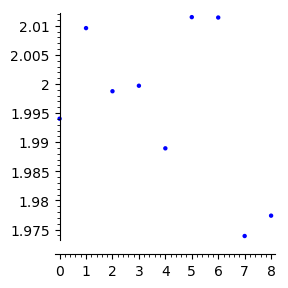

In [223]:
list_plot([PoleLemniskaty(1000*k) for k in range(1,10)],figsize=[3,3])

Przy wyborze niewielkiej liczby punktów próbkujących dokładność jest niezadowalająca. Jedną z przyczyn kłopotów z dobrym przybliżeniem jest też jakość próbek losowych pochodzących z funkcji `random`.

In [209]:
PoleLemniskaty(5)

2.82842712474619

In [214]:
PoleLemniskaty(500)

2.00818325856980

In [207]:
PoleLemniskaty(50000)

2.00224356160783

<h2>Metoda numeryczna 2</h2>
    <h3> Całkowanie z wykorzystaniem spacerów losowych</h3>

<div class="alert alert-block alert-success"> 
W ostatniej części postawimy sobie ambitniejsze zadanie. Zakładamy na początek, że mamy do dyspozycji tylko prosty generator bitowy `genbit` (który zwraca wartości $0$ i $1$ z prawdopodobieństwem bliskim $50\%$).

Skonstruujemy na bazie generatora bitowego zmienną losową `step`, która z prawdopodobieństwem $1/4$ zwraca wartość $-1$, z prawdopodobieństwem $1/2$ zwraca wartość $0$ i z prawdopodobieństwem $1/4$ zwraca wartość $1$.

Zmienna $K$ może posłużyć do konstrukcji spaceru losowego po prostej, w którym połowę czasu spędzamy stojąc w miejscu.</div>


In [233]:
def genbit():
    return choice([0,1])

In [239]:
proba=100000
probka=[genbit() for _ in range(0,proba)]

print("Częstość zer = "+str(probka.count(0)/proba*1.0))
print("Częstość jedynek = "+str(probka.count(1)/proba*1.0))

Częstość zer = 0.501960000000000
Częstość jedynek = 0.498040000000000


In [240]:
def step():
    go=genbit()
    if go==1:
        left=genbit()
        if left==1:
            return -1
        else:
            return 1
    else:
        return 0

Zbadajmy numerycznie rozkłąd zmiennej losowej `step`

In [246]:
proba=1000
li=[step() for i in range(0,proba)]
le=li.count(-1)
st=li.count(0)
ri=li.count(1)
ll=len(li)
print(''.join(["P(step={})={}\n".format(x[0],x[1]*1.0/ll) for x in [(-1,le),(0,st),(1,ri)]]))

P(step=-1)=0.240000000000000
P(step=0)=0.508000000000000
P(step=1)=0.252000000000000



Dla ustalonej pozycji początkowej $\{-1,0,1\}$ konstruujemy dodatkową funkcję, która zwróci nam losową pozycję (stan) po zastosowaniu zmiennej `step`.

In [247]:
states=[-1,0,1]
def RandomStep(init):
    s=step()
    if s==0:
        return init
    else:
        return states[(init+s+1)%3]

In [248]:
proba=1000
li=[RandomStep(1) for i in range(0,proba)]
le=li.count(-1)
st=li.count(0)
ri=li.count(1)
ll=len(li)
print(''.join(["P(step={})={}\n".format(x[0],x[1]*1.0/ll) for x in [(-1,le),(0,st),(1,ri)]]))

P(step=-1)=0.253000000000000
P(step=0)=0.255000000000000
P(step=1)=0.492000000000000



<div class="alert alert-block alert-success"> 
Teraz naszym celem jest skonstruowanie zmiennej losowej, która przyjmuje jeden ze stanów $\{-1,0,1\}$ z prawdopodobieństwem $1/3$. Nie możemy bezpośrednio do tego celu wykorzystać naszej poprzedniej zmiennej, ale korzystając z niej możemy skonstruować łańcuch Markowa, który będzie miał tę cechę, że jego rozkład graniczny będzie jednostajny.</div>

Nasz łańcuch Markowa jest aperiodyczny i nierozkładalny, zatem posiada jedyny stan stacjonarny, do którego zbiega każdy stan początkowy. Stan stacjonarny odpowiada wektorowi własnemu (znormalizowanemu) podporządkowanemu wartości własnej $1$.

In [250]:
m=matrix([[1/2,1/4,1/4],[1/4,1/2,1/4],[1/4,1/4,1/2]])
m.eigenvalues()

[1, 1/4, 1/4]

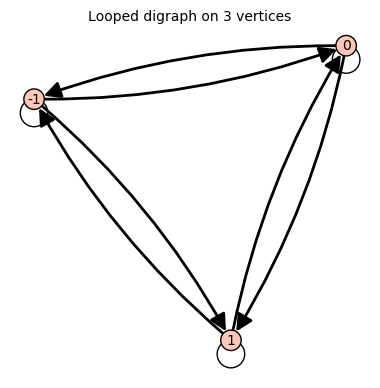

In [254]:
#graf łańcucha Markowa
g = DiGraph({-1: [-1,0,1], 0: [-1,0,1],1: [-1,0,1]}); g

In [266]:
pi_vec=m.eigenvectors_right()[0][1][0]*1/3

In [267]:
m*pi_vec==pi_vec

True

Tempo zbieżności do rozkładu stacjonarnego jest dość duże w tym przypadku

In [269]:
m^10*1.0

[0.333333969116211 0.333333015441895 0.333333015441895]
[0.333333015441895 0.333333969116211 0.333333015441895]
[0.333333015441895 0.333333015441895 0.333333969116211]

<div class="alert alert-block alert-success"> 
Poniżej konstruujemy funkcję, która przy zadanym stanie początkowym i odpowiednim czasie mieszania `mixing` generuje wartości zgodne z łańcuchem Markowa opisanym powyżej. Wykorzystanie `yield` pozwala nam utworzyć jeden proces, który będzie można wykorzystywać we wszystkich funkcjach.</div>

In [271]:
def MarkovChain(seed,mixing):
    state=seed
    #mieszanie początkowe dochodzące do stanu jednostajnego rozkładu
    for _ in range(0,mixing):
        state=RandomStep(state)
    while true:
        state=RandomStep(state)
        yield state

Sprawdzimy numerycznie własności naszego łańcucha Markowa

In [274]:
m1=MarkovChain(-1,500) #start w stanie -1 i "wygrzewanie" łańcucha w 500 krokach startowych 
                       #(aby zgubić początkowy rozkład)
le=0 #zliczanie wartości -1
st=0 #zliczanie wartości 0
ri=0 #zliczanie wartości 1
samp=50000 #rozmiar próby
for _ in range(0,samp):
    v=next(m1)
    if v==-1:
        le+=1
    else:
        if v==0:
            st+=1
        else:
            ri+=1
[x*1.0/samp for x in [le,st,ri]]

[0.336800000000000, 0.330300000000000, 0.332900000000000]

<div class="alert alert-block alert-success"> 
Na bazie łańcucha Markowa `MarkovChain` możemy utworzyć spacer losowy po grafie odwzorowującym punkty o współrzędnych całkowitych na płaszczyźnie. Taki spacer posłuży nam do generowania próbek losowych punktów na płaszczyźnie (po normalizacji).</div>

In [275]:
def RandomWalk(point):
    x,y=point
    mx=MarkovChain(0,500)
    my=MarkovChain(0,500)
    lipt=[(x,y)]
    while true:
        x+=next(mx) #modyfikacja zmiennej x za pomocą łańcucha mx
        y+=next(my) #modyfikacja zmiennej y za pomocą łańcucha my
        yield (x,y) #dodanie kolejnego punktu w spacerze 

Zobaczmy jak "wędruje" punkt po płaszczyźnie w spacerze losowym zadanym powyżej.

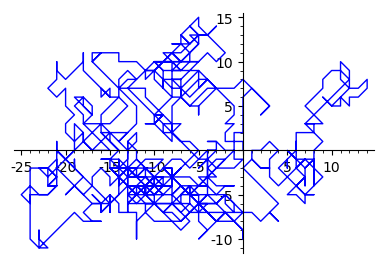

In [286]:
rw=RandomWalk((0,0))
lin=[(0,0)]

for _ in range(0,1000):
    pp=next(rw)
    lin.append(pp)
    
#show(pt)
show(line(lin),aspect_ratio=1,figsize=[4,4])

W praktyce interesuje nas spacer nie po nieograniczonej płaszczyźnie, ale po organiczonym jej kawałku. Aby zastosować taki efekt, utożsamiamy brzegi pewnego kwadratu, aby uzyskać topologiczny model torusa, na którym realizuje się nasz spacer losowy.

In [287]:
def RandomWalkWithBounds(point,size):
    x,y=point
    mx=MarkovChain(0,500)
    my=MarkovChain(0,500)
    lipt=[(x,y)]
    while true:
        x+=next(mx) #modyfikacja zmiennej x za pomocą łańcucha mx
        x=x%size
        y+=next(my) #modyfikacja zmiennej y za pomocą łańcucha my
        y=y%size
        yield (x,y) #dodanie kolejnego punktu w spacerze 

Poniżej prześledzimy na mapie częstości (im ciemniejszy piksel tym więcej odwiedzin) jak często dany punkt jest  odwiedzany w spacerze losowym. W granicy każdy punkt powinien być odwiedzany z tą samą częstotliwością.

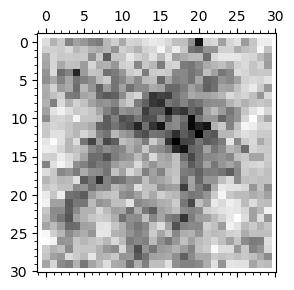

In [303]:
rozmiar=30
rw=RandomWalkWithBounds((rozmiar//2,rozmiar//2),rozmiar)
li1=[]
for _ in range(0,50000):
    li1.append(next(rw))

freq={(i,j):(li1.count((i,j))) for i in range(0,rozmiar) for j in range(0,rozmiar)}
m=max([freq[x] for x in freq])*1.0
M=matrix(RR,rozmiar,rozmiar,0)
for el in freq:
    M[el]=freq[el]/m
    
show(matrix_plot(M),figsize=[3,3])

Teraz możemy zdefiniować funkcję, która przy zadanym kształcie będzie zliczała odwiedziny.

In [304]:
def ShapeFunction(x,y,S):
    if S(x,y): #S jest warunkiem bycia wewnątrz kształtu
        return 1
    else:
        return 0
    
S1=(lambda x,y: y**2<=sqrt(4*x**2 + 1)-x**2 - 1) # wnętrze lemniskaty

I jeszcze jedna techniczna funkcja skalująca.

In [308]:
def MapFunction(a,b,xbound,xsize,ybound,ysize): #(a,b) w [0,1]^2
    return xbound+a*xsize,ybound+b*ysize

<div class="alert alert-block alert-success"> 
Teraz możemy już przygotować schemat całkowania metodą Monte Carlo z wykorzystaniem spaceru losowego. Po zainicjalizowaniu spaceru zliczamy te punkty wewnątrz kształtu, które odwiedziliśmy w trakcie spaceru. Zgodnie ze spodziewanym rozkładem jednostajnym zliczamy częstość odwiedzonych punktów w stosunku do wszystkich i mnożąc przez rozmiar próbkowanej przestrzeni.</div>

In [309]:
def CalkowanieMarkowa(start,steps,size,S,xbound,xsize,ybound,ysize):
    s=0
    rw=RandomWalkWithBounds(start,size)
    for _ in range(0,steps):
        a,b=next(rw)
        x,y=MapFunction(a*1.0/size,b*1.0/size,xbound,xsize,ybound,ysize)
        s+=ShapeFunction(x,y,S)
    return s*(xsize)*(ysize)/steps

Przy nawet stosunkowo małych rozdzielczościach próbkowania (przykład poniżej dla 30 i 40 punktów w każdym z kierunków) i niezbyt dużej liczbie iteracji, otrzymujemy zadowalające przybliżenie wyniku.

In [315]:
CalkowanieMarkowa((15,15),5,30,S1,-sqrt(2).n(),2*sqrt(2).n(),-1/2,1)

2.82842712474619

In [316]:
CalkowanieMarkowa((15,15),500,30,S1,-sqrt(2).n(),2*sqrt(2).n(),-1/2,1)

1.94030100757589

In [324]:
CalkowanieMarkowa((15,15),50000,30,S1,-sqrt(2).n(),2*sqrt(2).n(),-1/2,1)

2.00659933937994

<div class="alert alert-block alert-info"> 
Przy rozdzielczości $40\times 40$ punktów kraty i $2000$ iteracji otrzymujemy, że średnia wartość obliczonego metodą Monte Carlo pola ma błąd poniżej 0.05, a mediana przypada na wartość, której odchylenie również mieści się w zakresie około $0.01$.</div>

Na wykresie poniżej prezentujemy rozkład wartości pola dla 100 prób wykonanych obliczeń. 

1.99339058470737
2.01808275350641


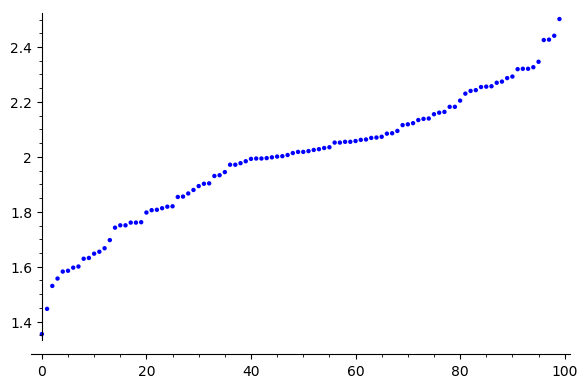

In [339]:
li=[CalkowanieMarkowa((randint(0,40),randint(0,40)),2000,40,S1,-sqrt(2).n(),2*sqrt(2).n(),-1/2,1)*1.0 for i in [1..100]] 
print sum(li)/len(li) #wartość średnia po wielu iteracjach
li.sort()
print li[floor(len(li)/2)] #wartość środkowa (mediana)
list_plot(li)